In [1]:
#bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
#carregar as bases de treino e de teste
treino = pd.read_csv(r'C:\Users\Maria\Desktop\projeto_floresta_aleatoria\train_floresta.csv')
teste = pd.read_csv(r'C:\Users\Maria\Desktop\projeto_floresta_aleatoria\train_floresta.csv')

In [3]:
#configurações
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#cinco primeiras linhas do dataset
treino.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [5]:
#linhas e colunas
treino.shape

(59598, 24)

In [6]:
#colunas do dataset
treino.columns

Index(['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role',
       'Monthly Income', 'Work-Life Balance', 'Job Satisfaction',
       'Performance Rating', 'Number of Promotions', 'Overtime',
       'Distance from Home', 'Education Level', 'Marital Status',
       'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure',
       'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities',
       'Company Reputation', 'Employee Recognition', 'Attrition'],
      dtype='object')

In [7]:
#estatística básica
treino.iloc[:,1:23].describe()

,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure
count,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000
mean,38.565875,15.753901,7302.397983,0.832578,50.007651,1.648075,55.758415
std,12.079673,11.245981,2151.457423,0.994991,28.466459,1.555689,25.411090
min,18.000000,1.000000,1316.000000,0.000000,1.000000,0.000000,2.000000
25%,28.000000,7.000000,5658.000000,0.000000,25.000000,0.000000,36.000000
50%,39.000000,13.000000,7354.000000,1.000000,50.000000,1.000000,56.000000
75%,49.000000,23.000000,8880.000000,2.000000,75.000000,3.000000,76.000000
max,59.000000,51.000000,16149.000000,4.000000,99.000000,6.000000,128.000000


In [8]:
colunas = treino.iloc[:,1:23]
colunas.drop(columns= ['Monthly Income','Distance from Home','Company Tenure'], inplace=True)

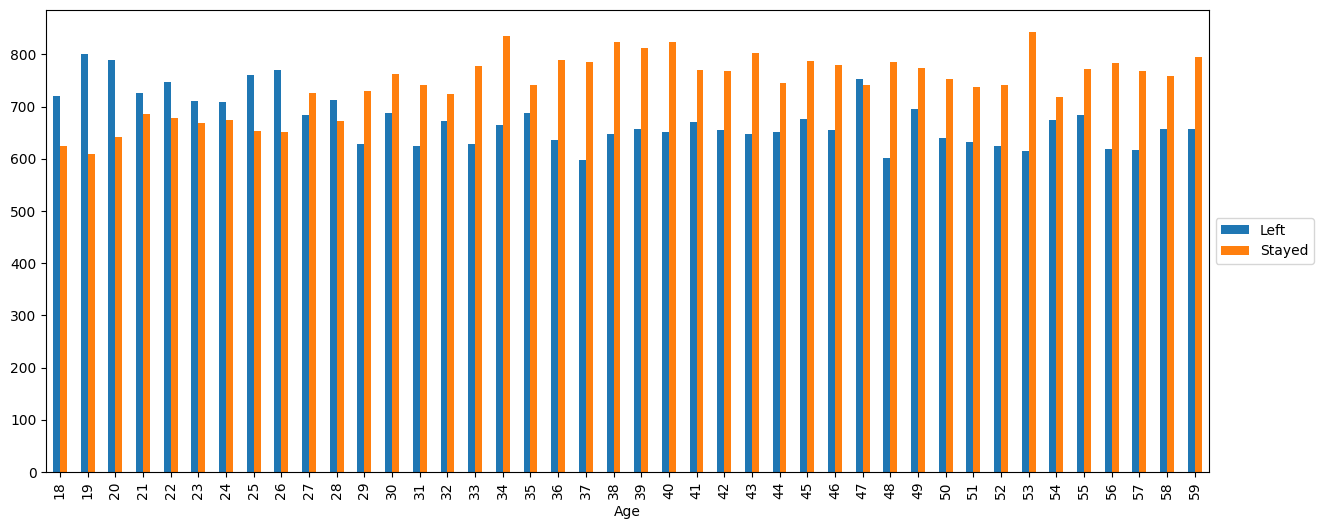

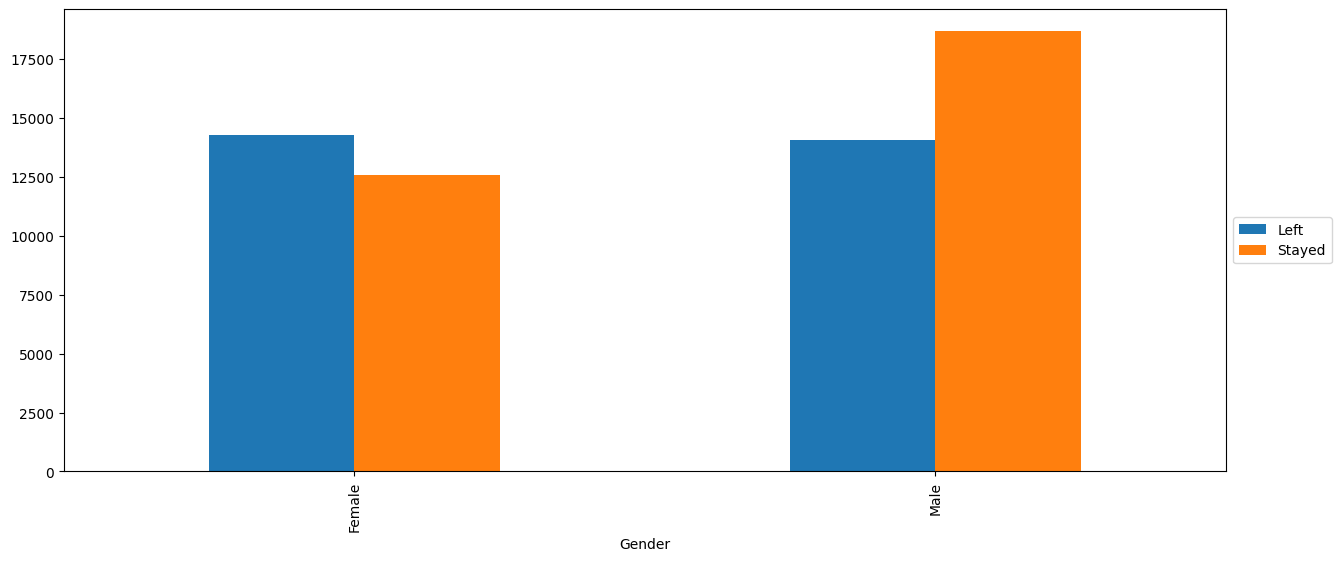

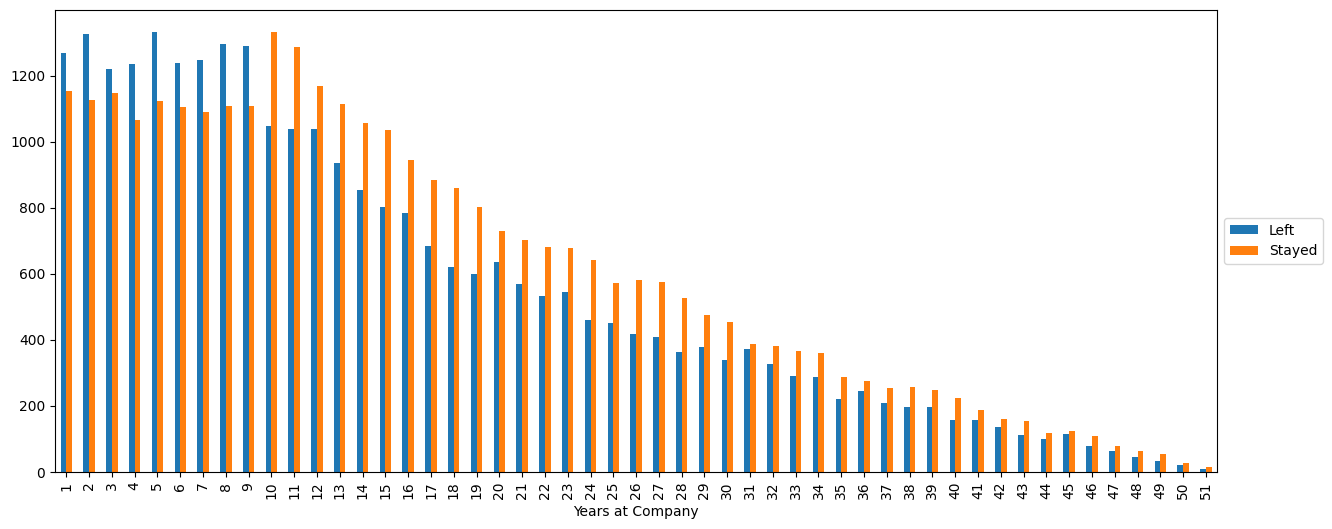

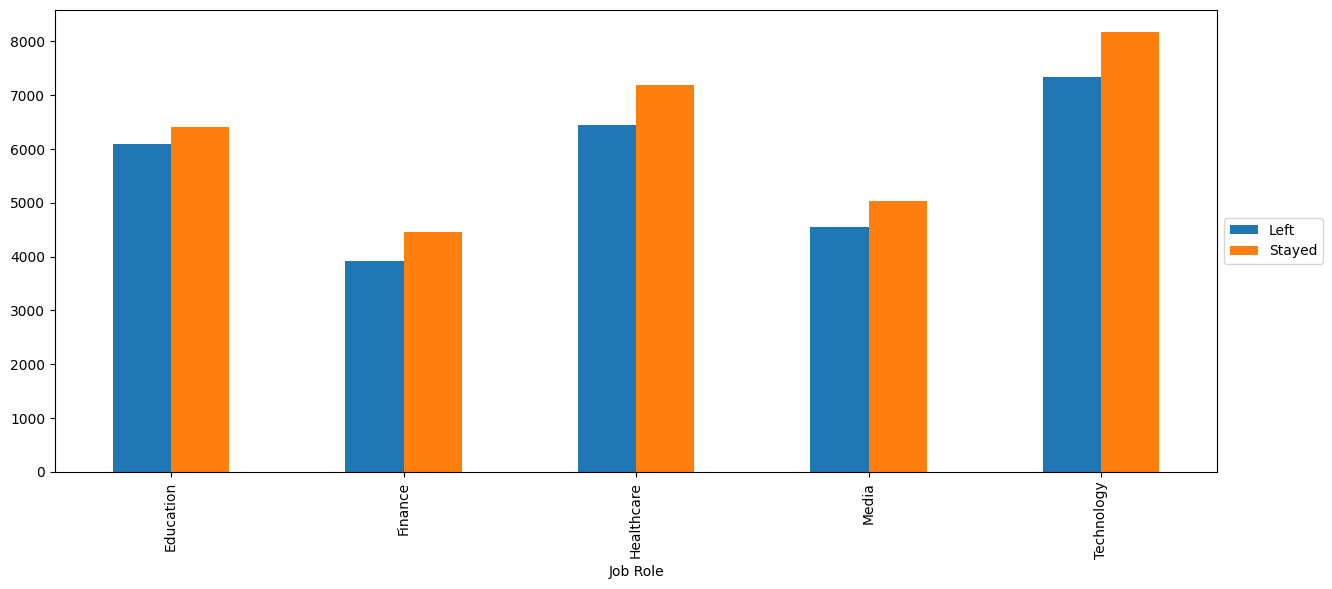

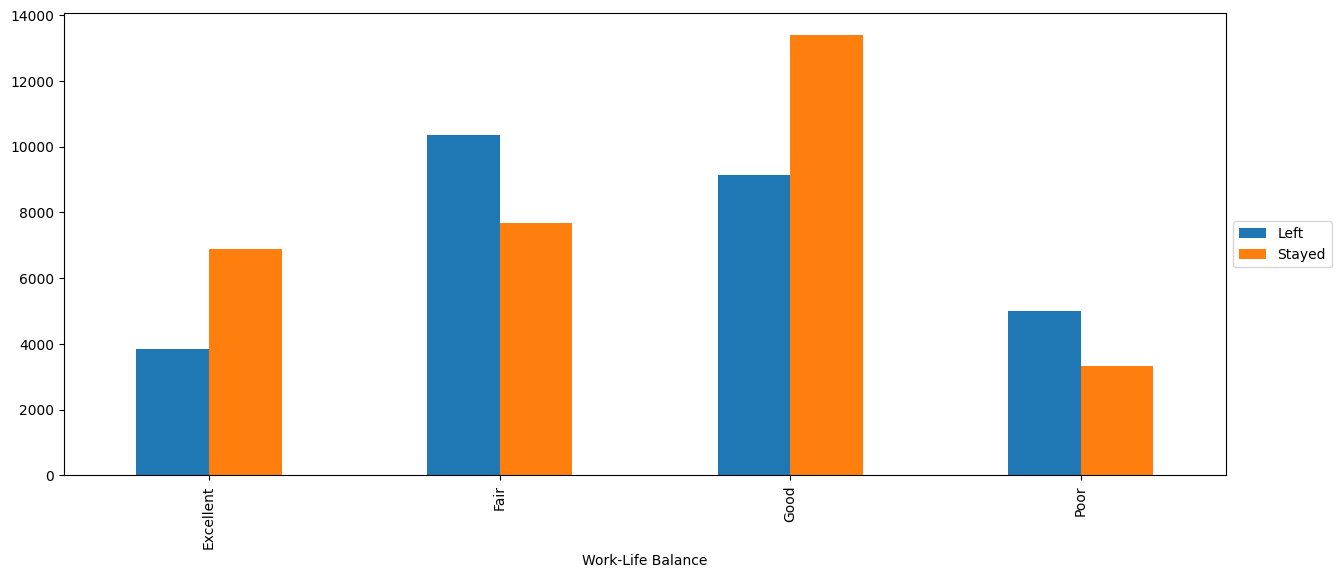

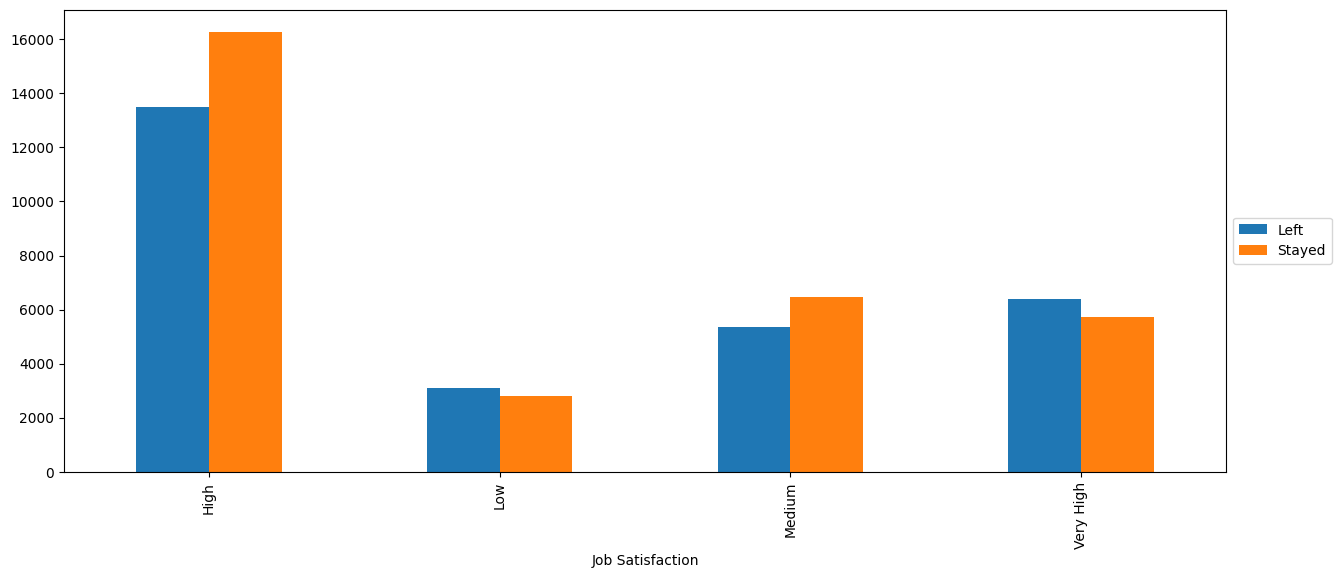

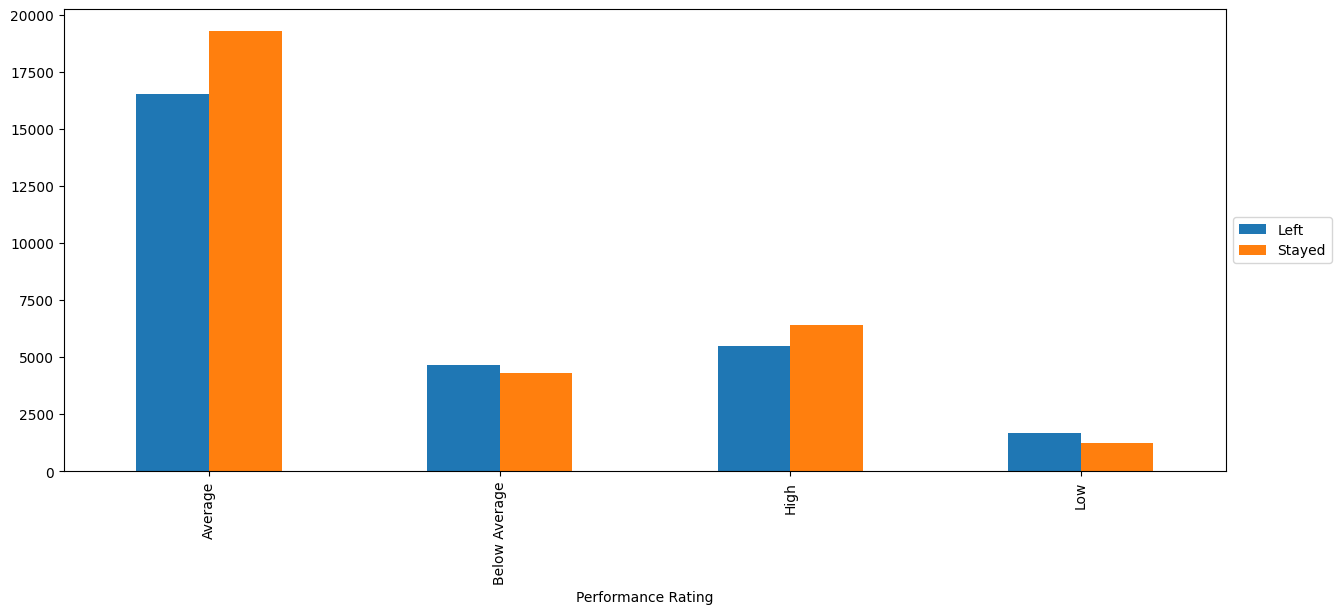

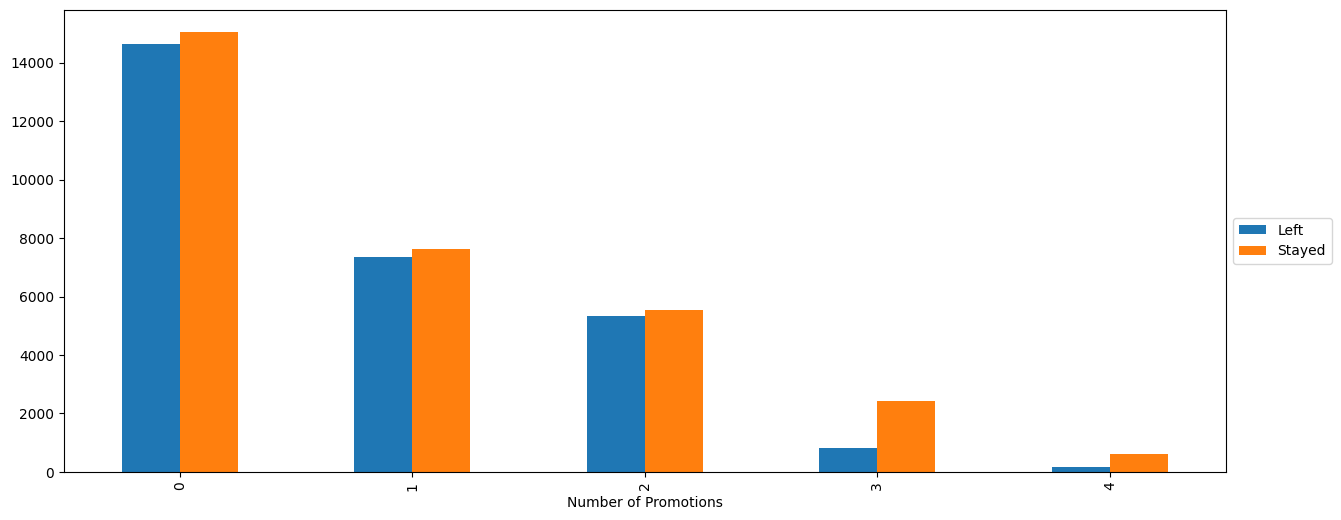

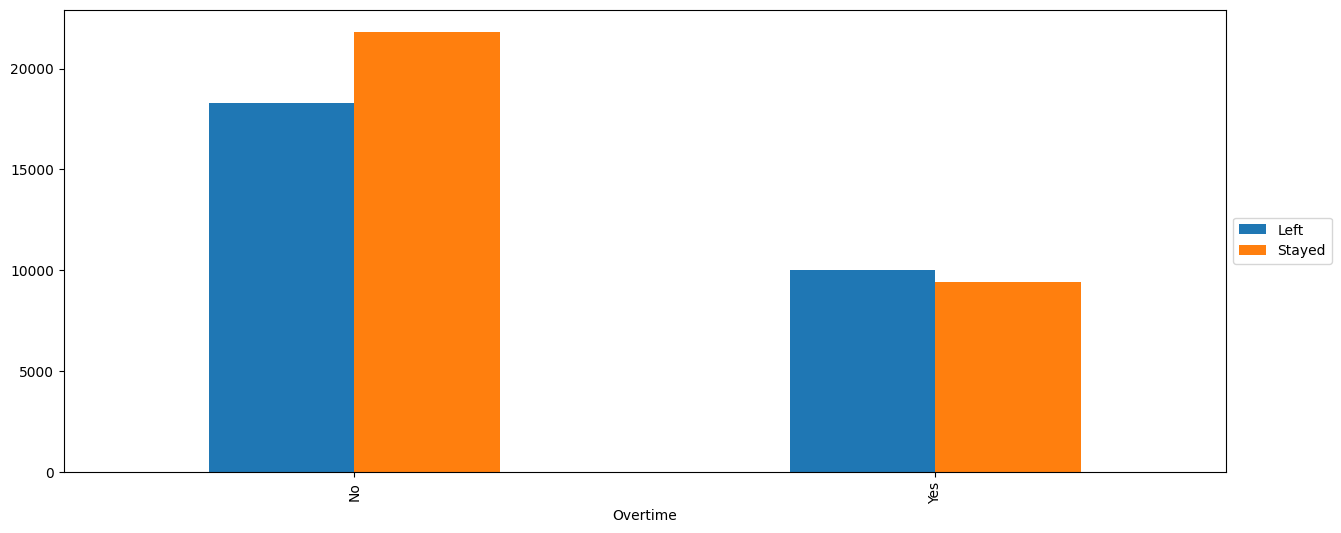

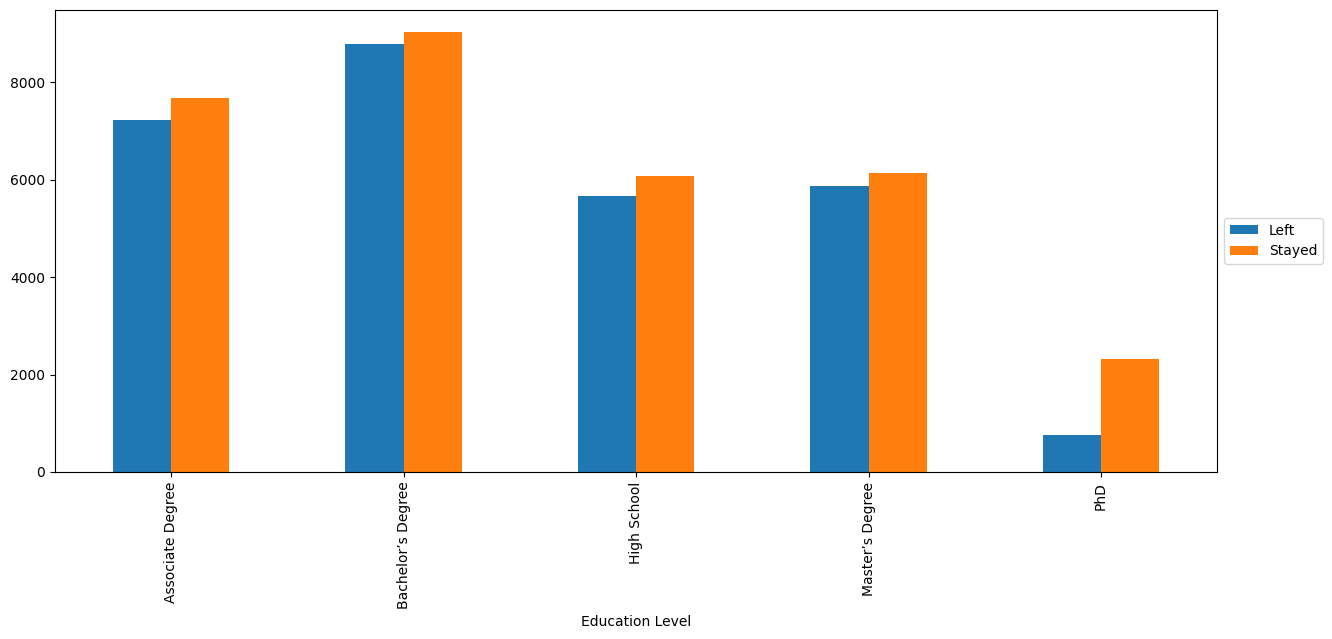

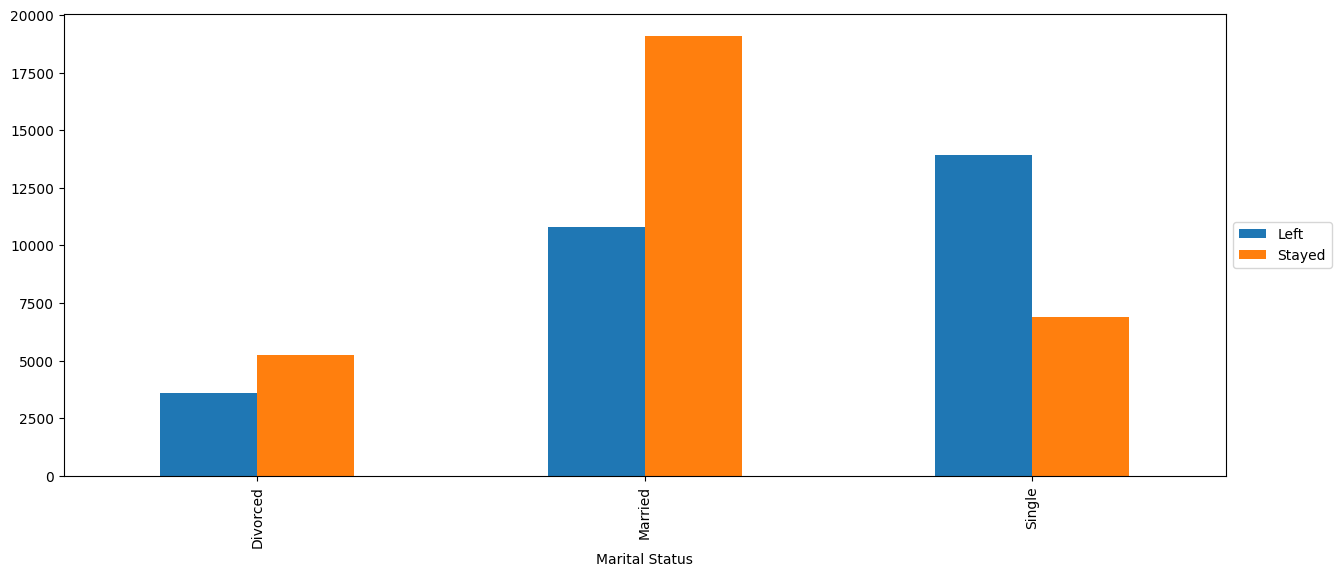

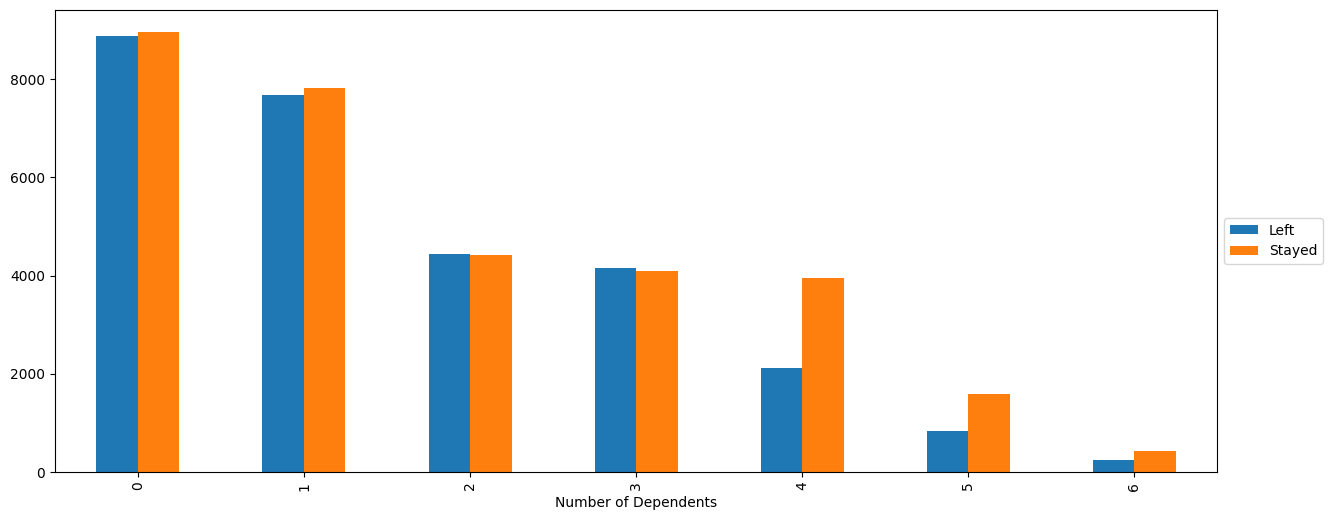

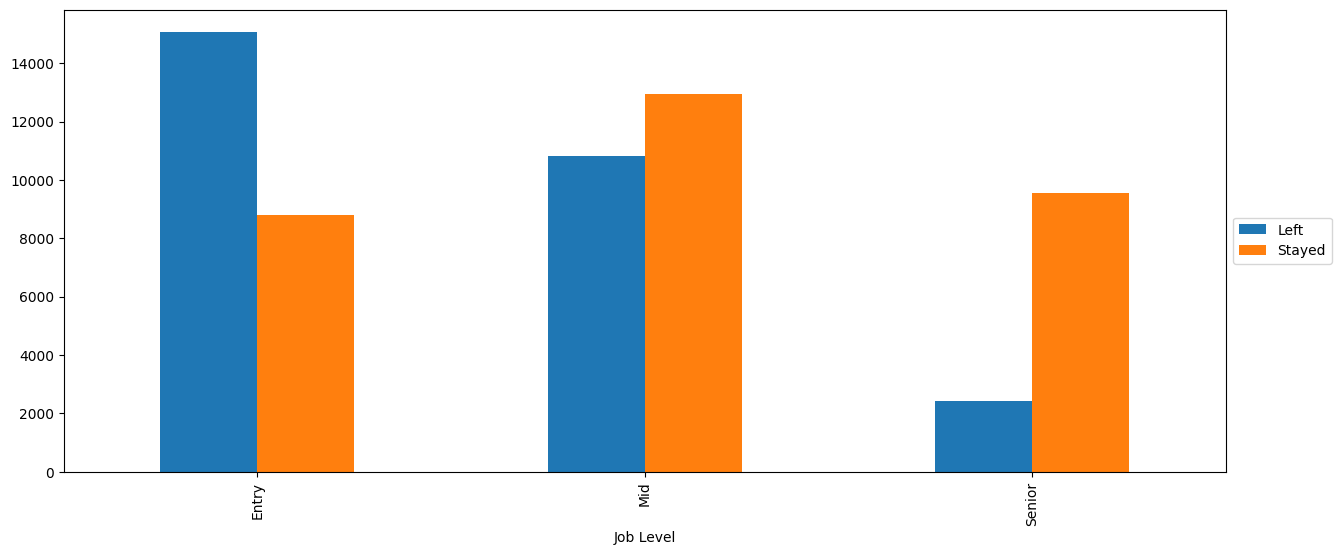

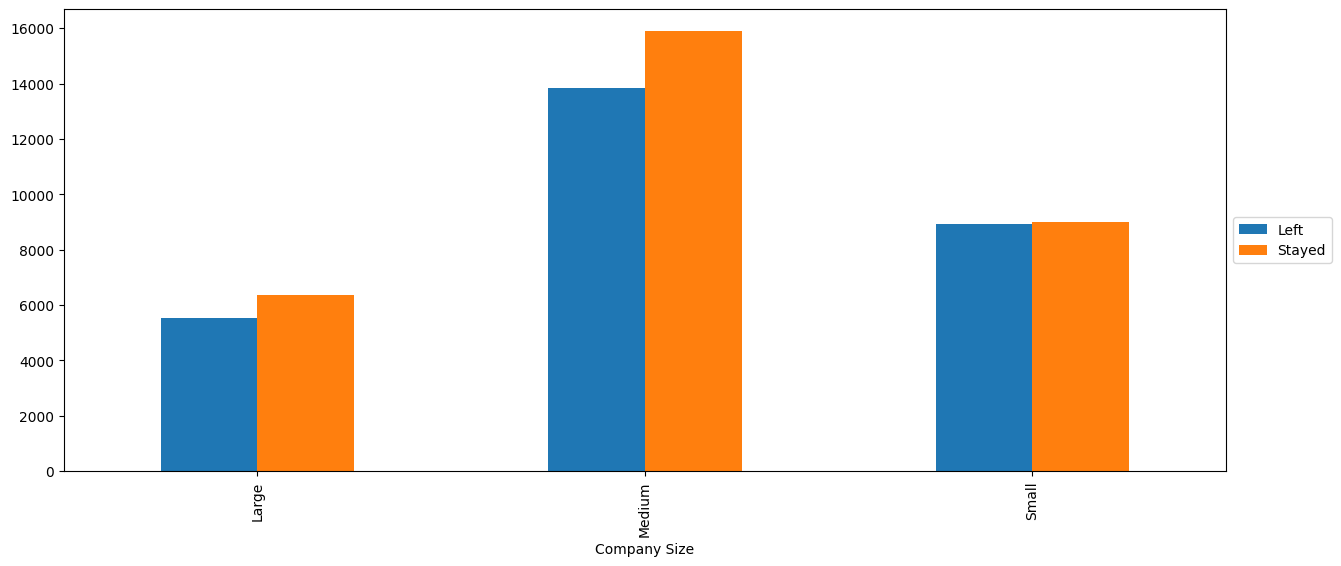

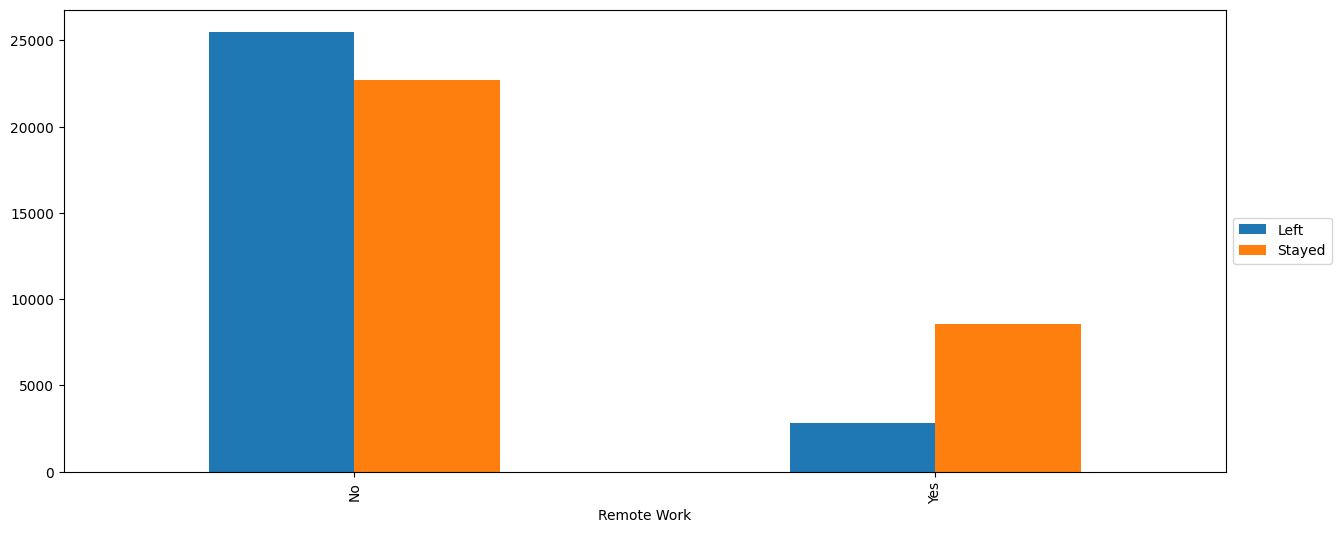

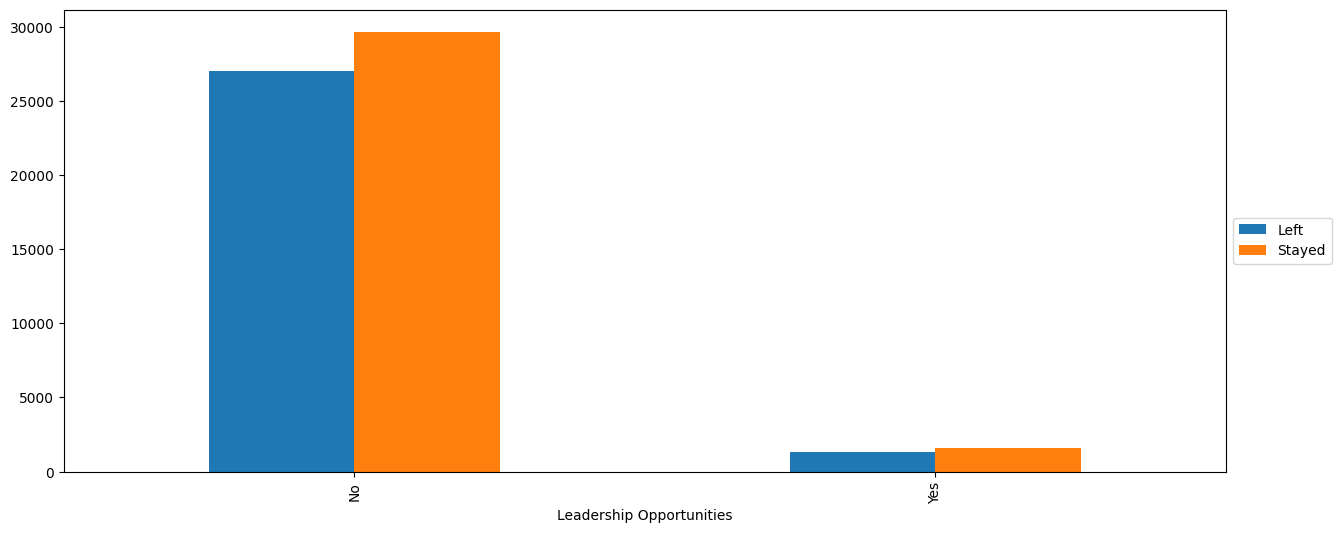

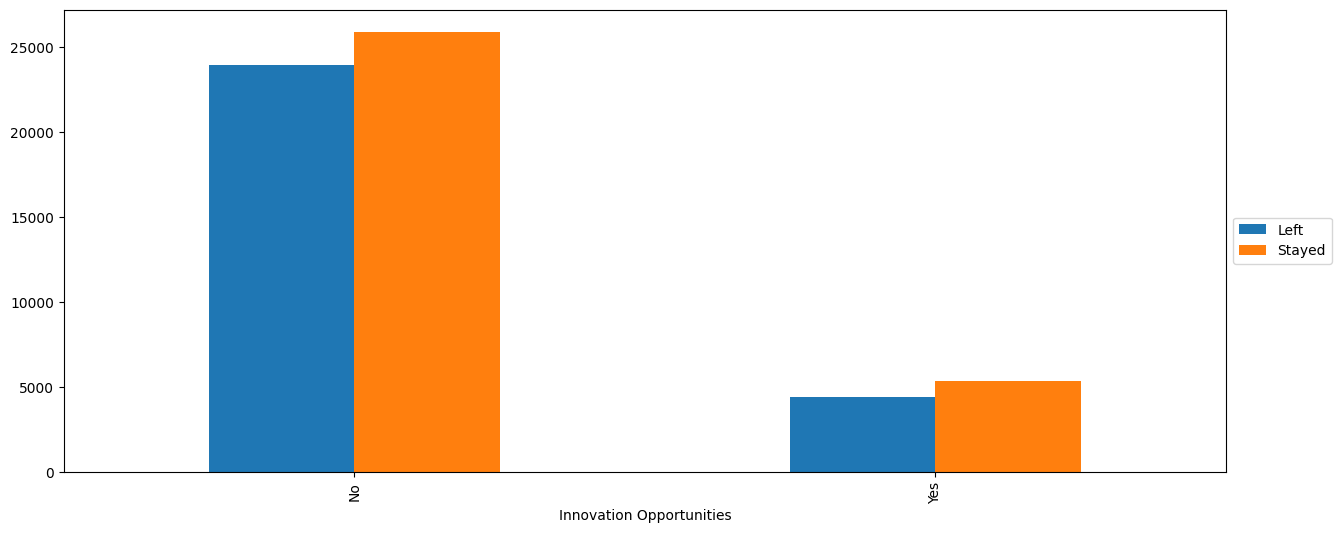

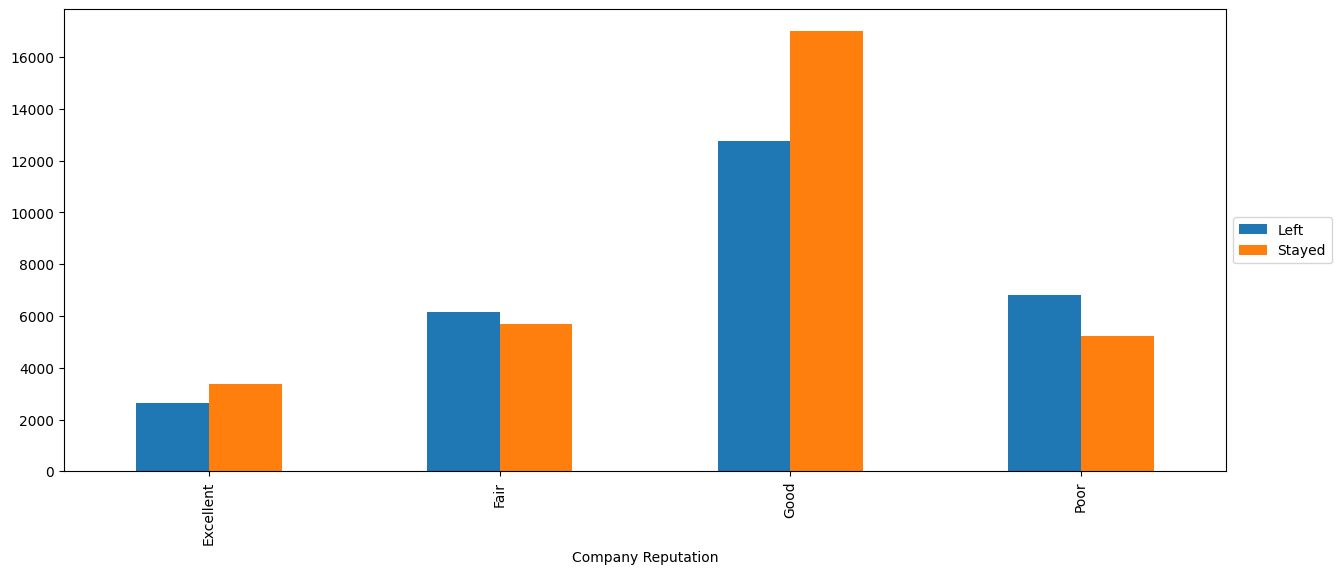

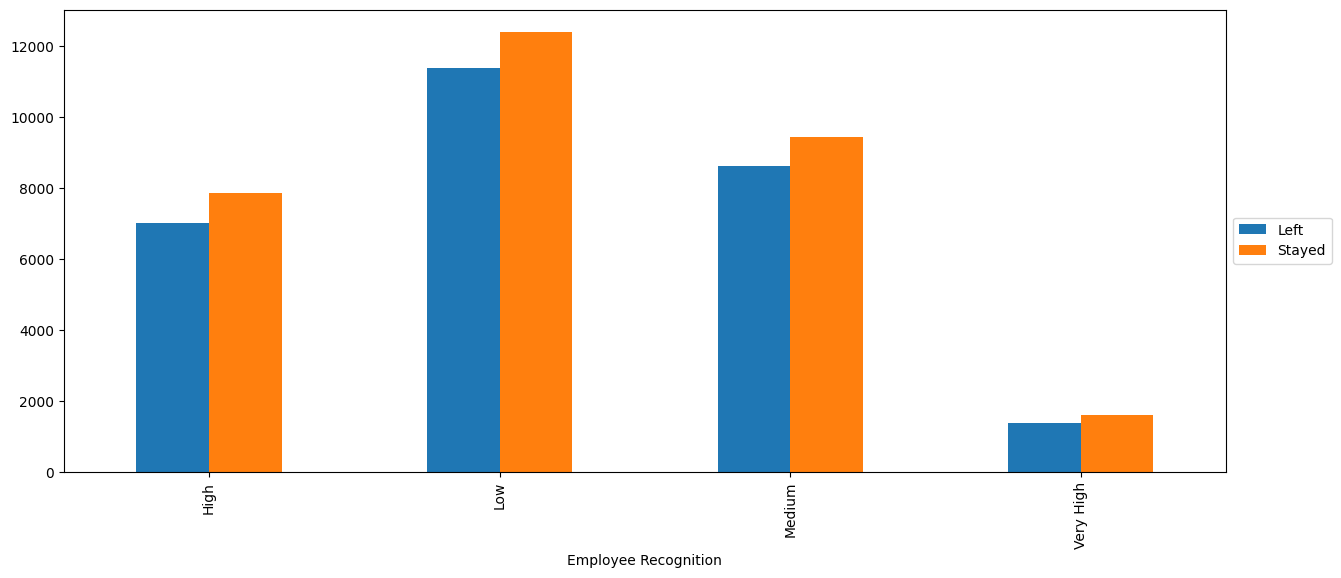

In [9]:
for coluna in colunas:
    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    agrupado.plot(kind='bar', figsize=(15,6))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [10]:
outras_colunas = treino[['Monthly Income','Distance from Home','Company Tenure']]

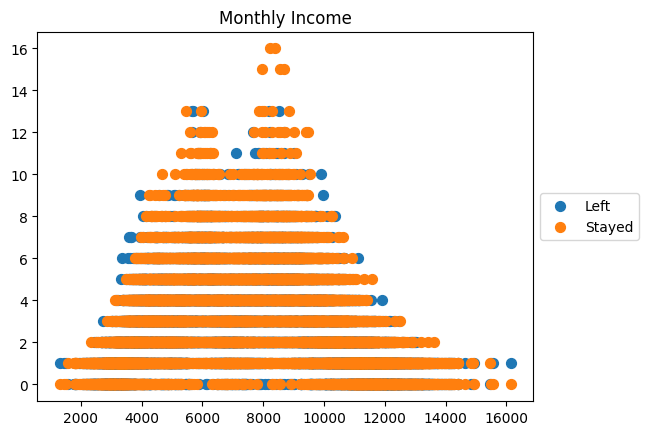

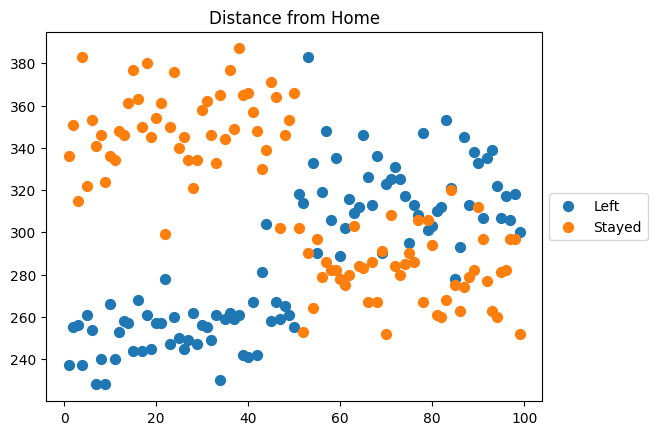

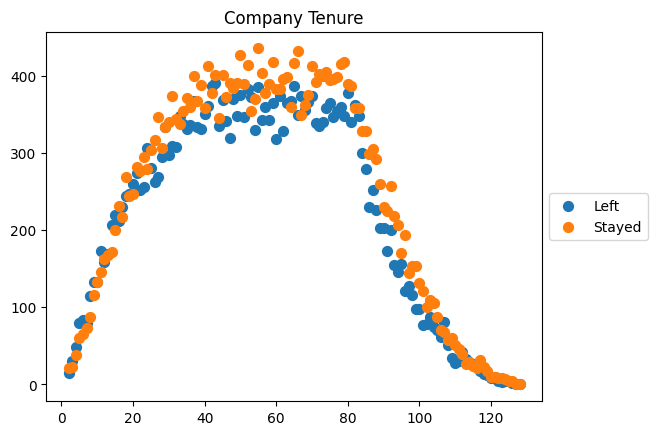

In [11]:
for coluna in outras_colunas:
    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    for categoria in agrupado.columns:
        plt.scatter(agrupado.index, agrupado[categoria], label=categoria, s=50)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(coluna)
    plt.show()

In [12]:
#separar target Y do dataset treino e teste
treino_y = treino['Attrition']
teste_y = teste['Attrition']

#remover target do dataset original
treino.drop(columns=['Attrition'], inplace=True)
teste.drop(columns=['Attrition'], inplace=True)

In [42]:
#transformar a varuável target em binária
treino_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)
treino_y = teste_y.astype(int) 

teste_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)
teste_y = teste_y.astype(int) 

In [13]:
#colunas categóricas
col_cat = treino.select_dtypes(include=["object"]).columns

In [14]:
col_cat

Index(['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction',
       'Performance Rating', 'Overtime', 'Education Level', 'Marital Status',
       'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities',
       'Innovation Opportunities', 'Company Reputation',
       'Employee Recognition'],
      dtype='object')

In [18]:
#aplicar OneHotEncoding separadamente para treino e teste (fit)
encoder = OneHotEncoder(sparse_output=False)
treino_encoder = pd.DataFrame(encoder.fit_transform(treino[col_cat]))
teste_encoder = pd.DataFrame(encoder.transform(teste[col_cat]))

In [20]:
#mudar os nomes das colunas para os nomes OneHotEmcoding
treino_encoder.columns = encoder.get_feature_names_out(col_cat)
teste_encoder.columns = encoder.get_feature_names_out(col_cat)

In [23]:
#nova base de treino com as colunas processadas
treino_processado = treino.drop(columns=col_cat, axis=1).reset_index(drop=True)
treino_processado = pd.concat([treino_processado, treino_encoder], axis=1)

In [26]:
#nova base de teste com as colunas proecessadas
teste_processado = teste.drop(columns=col_cat, axis=1).reset_index(drop=True)
teste_processado = pd.concat([teste_processado, teste_encoder], axis=1)